## Convert shapefile into GeoJSON
* ogr2ogr -f GeoJSON -t_srs crs:84 -s_srs crs:84 ActiveRidges.geojson ActiveRidges_fromSeton_etal_2012.shp
* ogr2ogr -f GeoJSON -t_srs crs:84 -s_srs crs:84 ActiveRidges_analyzed.geojson 2016_ActiveRidges_analyzed.shp
* ogr2ogr -f GeoJSON -t_srs crs:84 -s_srs crs:84 ExcludedTier_Extinct_Ridges.geojson MacLeod_etal_ExcludedTier_Extinct_Ridges_Dec2016.shp
* ogr2ogr -f GeoJSON -t_srs crs:84 -s_srs crs:84 PrimaryTier_Extinct_Ridges.geojson MacLeod_etal_PrimaryTier_Extinct_Ridges_Dec2016.shp
* ogr2ogr -f GeoJSON -t_srs crs:84 -s_srs crs:84 SecondaryTier_Extinct_Ridges.geojson MacLeod_etal_SecondaryTier_Extinct_Ridges_Dec2016.shp

In [19]:
class PrettyFloat(float):
    def __repr__(self):
        return '%.2f' % self

def pretty_floats(obj):
    if isinstance(obj, float):
        return PrettyFloat(obj)
    elif isinstance(obj, dict):
        return dict((k, pretty_floats(v)) for k, v in obj.items())
    elif isinstance(obj, (list, tuple)):
        return map(pretty_floats, obj)
    return obj


import json, glob, os

base_url = '/static/html/ExRidges/'
default_name = 'not_available.html'
base_dir = '/home/mchin/workspace/sarah/Revised_Portal_Dec2016/'
active_ridges = base_dir + 'Active_ridges/ActiveRidges.geojson'
active_ridges_analyzed = base_dir + 'Shapefiles/ActiveRidges_analyzed.geojson'
excluded_tier_extinct_ridges = base_dir + 'Shapefiles/ExcludedTier_Extinct_Ridges.geojson'
primary_tier_extinct_ridges = base_dir + 'Shapefiles/PrimaryTier_Extinct_Ridges.geojson'  
secondary_tier_extinct_ridges = base_dir + 'Shapefiles/SecondaryTier_Extinct_Ridges.geojson'


RED = [1.0, 0.0, 0.0, 1.0]
PINK = [255.0/255, 192.0/255, 203.0/255, 1.0]
YELLOW = [1.0,1.0,0.0,1.0]
BLUE = [0.0,0.0,1.0,1.0]
DARK_ORANGE = [1.0, 140.0/255, 0]
PURPLE = [160.0/255, 32.0/255.0, 240.0/255.0]

new_data = {"type": "FeatureCollection"}
new_data["features"] = [] 

cnt = 0

for r in [active_ridges, 
          active_ridges_analyzed, 
          excluded_tier_extinct_ridges, 
          primary_tier_extinct_ridges, 
          secondary_tier_extinct_ridges]:
    
    with open(r) as f:
        data = json.load(f)
        for f in data["features"]:
            cnt += 1
            feature = {"type": "Feature"}
            feature["geometry"] = f["geometry"]
            feature["properties"] = {}
            feature["properties"]["width"] = 3.0
            if r == active_ridges:
                feature["properties"]["color"] = DARK_ORANGE
                feature["properties"]["width"] = 1.0
                feature["properties"]["Tier"] = 'None'
                feature["properties"]['Ocean'] = 'None'
                feature["properties"]['RidgeTypeFlag'] = 'Active'
            elif r == active_ridges_analyzed:
                feature["properties"]["color"] = PURPLE
                try:
                    feature["properties"]['name'] = f["properties"]['NAME'][0:f["properties"]['NAME'].index('<')]
                except:
                    feature["properties"]['name'] = f["properties"]['NAME']
                feature["properties"]['RidgeTypeFlag'] = 'AnalyzedActive'
                feature["properties"]['AnalyzedActiveRidge'] = True
            elif r in [excluded_tier_extinct_ridges, 
                          primary_tier_extinct_ridges, 
                          secondary_tier_extinct_ridges]:
                feature["properties"] = f["properties"]
                feature["properties"]["width"] = 3.0
                feature["properties"]['RidgeTypeFlag'] = 'Extinct'
                
                if r == excluded_tier_extinct_ridges:
                    feature["properties"]["color"] = YELLOW
                elif r == primary_tier_extinct_ridges: 
                    feature["properties"]["color"] = RED
                elif r == secondary_tier_extinct_ridges:
                    feature["properties"]["color"] = PINK
                else:
                    feature["properties"]["color"] = [0.0,0.0,0.0,1.0]
                    
                feature["properties"]["name"] = f["properties"]["SegmentFul"]
                del feature["properties"]["SegmentFul"]
            #feature["properties"]["ID"] = f["properties"]["SEG_ID"]
            feature["properties"]["ID"] = str(cnt)
            #del feature["properties"]["SEG_ID"]
            
            full_file_path = ''
            if 'htmlPage' in f["properties"]:
                full_file_path = base_dir+'ExRidges_HTML_pages/{}'.format(f["properties"]["htmlPage"])
            elif 'HTMLPage' in f["properties"]:
                full_file_path = base_dir+'ExRidges_HTML_pages/{}'.format(f["properties"]["HTMLPage"])
            
                
            if os.path.isfile(full_file_path):
                feature["properties"]["URL"] = base_url+"ExRidges_HTML_pages/" + os.path.basename(full_file_path)
            else:
                feature["properties"]["URL"] = None
                
            new_data["features"].append(feature)

for t in new_data["features"]:
    if not t['properties']:
        print t

with open(base_dir + 'ExRidges_new.geojson', "w") as fo:
    fo.write(json.dumps(pretty_floats(new_data)))
print 'done'

done


# Make image from NetCDF grid file

## Step 1: Split the large grid file

In [ ]:
ROOT_PATH = "/mnt/workspace/sarah/Portal_ExRidges"
import sys
sys.path.append(ROOT_PATH)
import split_grid, shading
import struct, math, gzip, os
import numpy
from osgeo import gdal
from gdalconst import *
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hsv_to_rgb 
%matplotlib inline

from pylab import *

count = 10
show_img_flag = False;

In [ ]:
input_file = ROOT_PATH + '/GEBCO_2014_1D.nc'
output_dir = ROOT_PATH + '/GEBCO_2014_1D_pieces/'
            
split_grid.split_grid(input_file,output_dir,count)


## Step 2: Apply colours and shading

In [ ]:
lon_inc = 360/count
lat_inc = 180/count

#x_idx = [1]
#y_idx = [4]
x_idx = range(count)
y_idx = range(count)
root_dir = ROOT_PATH
output_dir= root_dir + '/results/'

def toRGB(data): 
    hsv = data.split('-')
    return hsv_to_rgb([float(hsv[0])/360.0, float(hsv[1]), float(hsv[2])])

def gmtColormap(filePath):
    steps = []
    colors = []
    with open(filePath,'r') as f:
        lines = f.readlines()
        for l in lines:
            ls = l.split()
            if ls[0] == '#' or ls[0] == "B" or ls[0] == "F" or ls[0] == "N":
                continue
            else:
                steps.append(float(ls[0]))
                steps.append(float(ls[2]))
                colors.append(toRGB(ls[1]))
                colors.append(toRGB(ls[3]))
    
    color_list = []
    for i in range(len(steps)):
        color_list.append((float(steps[i]-steps[0])/(steps[-1]-steps[0]), colors[i]))
 
    #print color_list
    return LinearSegmentedColormap.from_list('cmap', color_list, N=1024)

def gmtColormap_1(filePath):
    steps = []
    colors = []
    with open(filePath,'r') as f:
        lines = f.readlines()
        for l in lines:
            ls = l.split()
            if ls[0] == '#' or ls[0] == "B" or ls[0] == "F" or ls[0] == "N":
                continue
            else:
                steps.append(float(ls[0]))
                steps.append(float(ls[4]))
                colors.append(hsv_to_rgb([float(ls[1])/360.0,float(ls[2]),float(ls[3])]))
                colors.append(hsv_to_rgb([float(ls[5])/360.0,float(ls[6]),float(ls[7])]))
    
    color_list = []
    for i in range(len(steps)):
        color_list.append((float(steps[i]-steps[0])/(steps[-1]-steps[0]), colors[i]))
 
    #print color_list
    return LinearSegmentedColormap.from_list('cmap', color_list, N=1024)

#cmap = gmtColormap(ROOT_PATH+"/Gebco_BathymetryTopo.cpt")
cmap = gmtColormap_1(ROOT_PATH+"/topo.cpt")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in x_idx:
    for j in y_idx:
        dataset = gdal.Open(root_dir + '/GEBCO_2014_1D_pieces/{0}_{1}.tif'.format(i,j), GA_ReadOnly )
        band = dataset.GetRasterBand(1)
        r = band.ReadAsArray( 0, 0, band.XSize, band.YSize, band.XSize, band.YSize)
        #r = band.ReadAsArray( 0, 0, band.XSize, band.YSize, 3600, 1800)
        fig = plt.figure(figsize=(36, 18),dpi=240, frameon=False)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.ioff()
        
        '''
        You must be careful with the Nan data in the grid.
        '''
        where_are_NaNs = isnan(r)
        r[where_are_NaNs] = 0
        
        rgb = shading.shade(r,cmap=cmap,intensity=shading.intensity(r),vmin=-7000, vmax=7000)
        plt.imshow(rgb)
        #plt.imshow(r,cmap=cmap,vmin=-10927.5, vmax=8726)

        fig.savefig(output_dir+'{0}_{1}.tif'.format(i,j),pad_inches=0,dpi=240)

        '''
            If the image saved by matplotlib has the annoying frame margin, use the following imagemagic command to get rid of it.
            You might need to use "transparent=True," when saving the image with matplotlib.
        '''
        #cmd = "convert "+output_dir+'{0}_{1}_topo15.tif '.format(i,j) +" -trim "+ output_dir+'{0}_{1}_topo15_trimmed.tif'.format(i,j)
        #os.system(cmd)

        ulx=-180+i*lon_inc
        uly=90-j*lat_inc
        lrx=-180+(i+1)*lon_inc
        lry=90-(j+1)*lat_inc
        '''
        Georeference the image pieces.
        '''
        cmd = "gdal_translate -a_ullr {0} {1} {2} {3} ".format(ulx,uly,lrx,lry) + output_dir+'{0}_{1}.tif '.\
        format(i,j) + output_dir+'{0}_{1}_ref.tif '.format(i,j)
        print cmd
        print os.system(cmd)
        if not show_img_flag:
            plt.close()
        os.system("rm "+output_dir+'{0}_{1}.tif '.format(i,j))
print 'done'

##Step 3: create a virtual raster
    gdalbuildvrt my_vr.vrt *.tif
    
##Step 4: Cut the tiles
    gdal2tiles.py --profile=geodetic --zoom='0-8' -s EPSG:4326 --no-kml my_vr.vrt tiles 

40 40


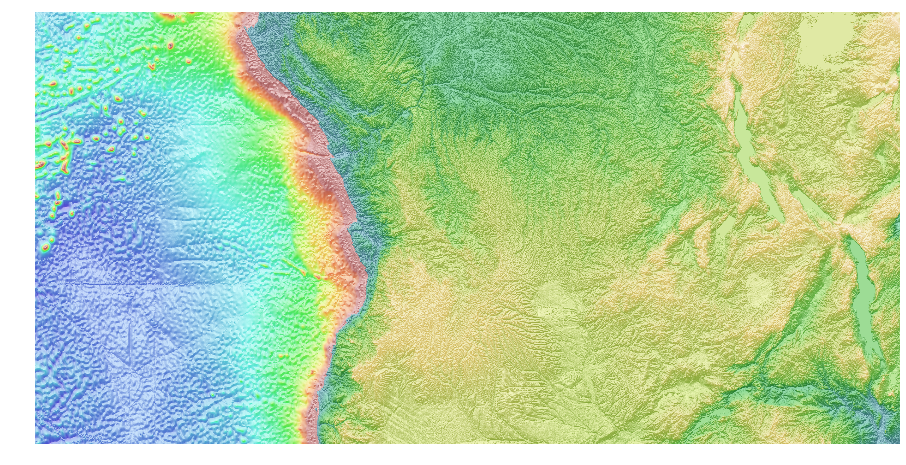

In [36]:
def gmtColormap_1(filePath):
    steps = []
    colors = []
    with open(filePath,'r') as f:
        lines = f.readlines()
        for l in lines:
            ls = l.split()
            if ls[0] == '#' or ls[0] == "B" or ls[0] == "F" or ls[0] == "N":
                continue
            else:
                steps.append(float(ls[0]))
                steps.append(float(ls[4]))
                colors.append(hsv_to_rgb([float(ls[1])/360.0,float(ls[2]),float(ls[3])]))
                colors.append(hsv_to_rgb([float(ls[5])/360.0,float(ls[6]),float(ls[7])]))
    
    color_list = []
    print len(steps), len(colors)
    for i in range(len(steps)):
        color_list.append((float(steps[i]-steps[0])/(steps[-1]-steps[0]), colors[i]))
 
    #print color_list
    return LinearSegmentedColormap.from_list('cmap', color_list, N=1024)

# test gmtColormap() function 
cmap = gmtColormap_1(ROOT_PATH + "/topo.cpt")
dataset = gdal.Open(root_dir + '/GEBCO_2014_1D_pieces/5_5.tif', GA_ReadOnly )
band = dataset.GetRasterBand(1)
#r = band.ReadAsArray( 0, 0, band.XSize, band.YSize, band.XSize, band.YSize)
r = band.ReadAsArray( 0, 0, band.XSize, band.YSize, 3600, 1800)
fig = plt.figure(figsize=(12, 6),dpi=240, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.ioff()

'''
You must be careful with the Nan data in the grid.
'''
where_are_NaNs = isnan(r)
r[where_are_NaNs] = 0

rgb = shading.shade(r,cmap=cmap,intensity=shading.intensity(r),vmin=-7000, vmax=7000)
plt.imshow(rgb)
plt.show()

40 40


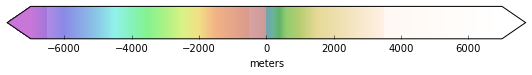

In [33]:
fig = plt.figure(figsize=(8, 3),dpi=300,frameon=False)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = gmtColormap_1(ROOT_PATH + "/topo.cpt")
norm = matplotlib.colors.Normalize(vmin=-7000, vmax=7000, clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal',
                                       extend='both',spacing='uniform',
                                       ticks=[-6000,-4000, -2000,  0,  2000, 4000, 6000])               
cb1.set_label('meters')
plt.show()